In [1]:
import os
from datetime import datetime
# Make logging folder named according to current time
start_time_str = datetime.today().strftime('%d_%m_%Y__%H_%M_%S')
log_dir = './logs/'f"log_{start_time_str}"
os.makedirs(log_dir)

# Initialize logger that adds to text file in current logging folder
from logging_utils import *


# Initialize logger that adds to text file in current logging folder
from logging_utils import *
init_logger(save_dir=log_dir)
logger = get_logger()

In [2]:
import pathlib
import subprocess
# Get the absolute path to your repository, 
# no matter where you are running this code from

repo_path = os.getcwd() 


git_branch = subprocess.check_output(
    ["git", "-C", repo_path, "rev-parse", "--abbrev-ref", "HEAD"]).strip().decode('UTF-8')

git_commit_short_hash = subprocess.check_output(
    ["git", "-C", repo_path, "describe", "--always"]).strip().decode('UTF-8')


In [3]:
from src_dir import *
import numpy as np

dim=25


x0=np.squeeze(np.zeros((dim,dim)))
x0Type='Zero Solution 2D'

# FD_StencilMat=np.zeros((dim,dim))
# b = np.ones(dim-1)
# c = -2*np.ones(dim)
# np.fill_diagonal(FD_StencilMat[1:], b)
# np.fill_diagonal(FD_StencilMat[:,1:], b)
# np.fill_diagonal(FD_StencilMat, c)
# A=FD_StencilMat
# A=np.asmatrix(A)

A=mk_laplace_2d(dim,dim)
AType='2D Laplacian'

retrain_freq=1
e1 = 1e-3
e2 = 1e-6
nmax_iter = int(dim/5)
restart   = 64

# sigma=0.02
sigma=0.2


DomainL=-1.0
DomainR=1.0

x1=np.linspace(DomainL,DomainR,dim)
x2=np.linspace(DomainL,DomainR,dim)
X, Y = np.meshgrid(x1, x2, sparse=False, indexing='ij')

n_steps =2000
InputDim=dim*dim
HiddenDim=dim*dim
OutputDim=dim*dim

In [4]:
# check 2d grid and RHS


import matplotlib.pyplot as pp
from mpl_toolkits.mplot3d import Axes3D


fig = pp.figure()
ax = fig.add_subplot(111, projection='3d')
ProbIdx=200

# Z=np.sin(1)*X+np.cos(1)*Y

xloc=np.cos(6*ProbIdx)*np.cos(ProbIdx)
yloc=np.cos(6*ProbIdx)*np.sin(ProbIdx)
Z=Gauss_pdf_2D(X,Y,xloc,yloc,sigma)

# Z=np.maximum(2*X*np.sin(ProbIdx),2*Y*np.cos(ProbIdx))

ax.plot_surface(X,Y,Z)

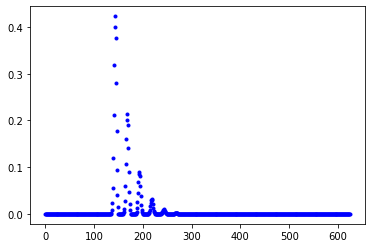

In [5]:
# Check that we flatten according to Fortran ordering(columnwise) 

Z[:,0:5]=0
b_test=np.reshape(Z.T,(1,-1),order='C')
b_norm=np.linalg.norm(b_test)
# print(b_test)
pp.plot((b_test.T)/b_norm,'.b')

In [6]:
# Initial log message
logger.info("Test 2D-Flat problem using 1DConv +1 FC. Dim 25. Wide point source constrained on rose k=6.  ")
#  The source is a narrow gaussian that depends on the integer 'time' in a nonlinear way. The gaussian is on the interval [-5,5], and constrained to move on [-3,3]. ")



# Set up parameter class
class MyParamsClass():
    def __init__(self, AType,dim,nmax_iter,restart,retrain_freq,e1,e2,x0Type,n_steps,InputDim,HiddenDim,OutputDim,sigma,DomainL,DomainR,git_branch,git_commit_short_hash):
        self.AType = AType
        self.dim = dim
        self.nmax_iter = nmax_iter
        self.restart = restart
        self.n_steps =n_steps
        self.retrain_freq=retrain_freq
        self.e1=e1
        self.e2=e2
        self.x0Type=x0Type
        self.InputDim=InputDim
        self.HiddenDim=HiddenDim
        self.OutputDim=OutputDim
        self.sigma=sigma
        self.DomainL=DomainL
        self.DomainR=DomainR
        self.git_branch=git_branch
        self.git_commit_short_hash=git_commit_short_hash





import os
import json

params = MyParamsClass(AType,dim,nmax_iter,restart,retrain_freq,e1,e2,x0Type,n_steps,InputDim,HiddenDim,OutputDim,sigma,DomainL,DomainR,git_branch,git_commit_short_hash)
sorted_params_dict = {k: params.__dict__[k] for k 
                      in sorted(params.__dict__.keys())}

params_filepath = log_dir+'/params.json'
json.dump(sorted_params_dict, open(params_filepath, 'w'), indent=4)

2020-06-23 01:30:03 [INFO] <ipython-input-6-cbe0dc0d7b39> 2 - Test 2D-Flat problem using 1DConv +1 FC. Dim 25. Wide point source constrained on rose k=6.  


In [7]:
from src_dir import *

# @nn_preconditioner(retrain_freq=retrain_freq, debug=True,InputDim=InputDim,HiddenDim=HiddenDim,HiddenDim2=HiddenDim2,OutputDim=OutputDim)
# def MLGMRES(A, b, x0, e, nmax_iter,IterErr0_sum,IterErr0,ProbCount,Add,restart,debug):
#     return GMRES(A, b, x0, e, nmax_iter,restart, debug)



@timer
@cnn_preconditionerOnline_timed_2DFlat(retrain_freq=retrain_freq, debug=True,InputDim=InputDim,HiddenDim=HiddenDim,OutputDim=OutputDim)
def MLGMRES(A, b,b_flat ,x0,e,nmax_iter,ML_GMRES_Time_list,ProbCount,restart,debug,refine,blist,reslist,Err_list,ML_GMRES_Time_list2):
    return GMRES(A, b, x0, e, nmax_iter,restart, debug)



@timer
def GMRES_timed(A, b, x0, e, nmax_iter,restart,debug):
    return GMRES(A, b, x0, e, nmax_iter,restart, debug)

In [8]:
from src_dir import *



ML_GMRES_Time_list=[]
ML_GMRES_Time_list2=[]

Err_list=[]
NonML_Err_List=[]

run_time_ML_list=[]
run_timeP1_ML_list=[]
run_timeP2_ML_list=[]

run_time_list=[]
GmresRunTimeOriginal=[]
GmresRunTimeOriginal2=[]

trainTime_list=[]


debug=True
refine1=False
refine2=True

blist=[]
reslist=[]

eps=0.0001

for ProbIdx in range(n_steps):

    xloc=np.cos(6*ProbIdx)*np.cos(ProbIdx)
    yloc=np.cos(6*ProbIdx)*np.sin(ProbIdx)
    b=Gauss_pdf_2D(X,Y,xloc,yloc,sigma)

#     b=np.maximum(2*X*np.sin(ProbIdx),2*Y*np.cos(ProbIdx))


    b_flat=np.reshape(b.T,(1,-1),order='C').squeeze(0)
    b_norm=np.linalg.norm(b_flat)


    OutList1,run_time1_ML=MLGMRES(A, b/b_norm,b_flat/b_norm ,x0,e1, nmax_iter,ML_GMRES_Time_list,ProbIdx,restart,debug,refine1,blist,reslist,Err_list,ML_GMRES_Time_list2)  # normalize b for optimal NN performance.
    Out=OutList1[0]
    ML_GMRES_Time_list=OutList1[1]
    trainTime_list.append(OutList1[2])
    blist=OutList1[3]
    reslist=OutList1[4]
    Err_list=OutList1[5]

    OutList2,run_time2_ML=MLGMRES(A, b/b_norm,b_flat/b_norm,Out[-1], e2, nmax_iter,ML_GMRES_Time_list,ProbIdx,restart,debug,refine2,blist,reslist,Err_list,ML_GMRES_Time_list2)
    Out2=OutList2[0]
    ML_GMRES_Time_list=OutList2[1]
    trainTime_list.append(OutList2[2])
    blist=OutList2[3]
    reslist=OutList2[4]
    Err_list=OutList2[5]
    ML_GMRES_Time_list2=OutList2[6]

    run_timeP1_ML_list.append(run_time1_ML)
    run_timeP2_ML_list.append(run_time2_ML)
    run_time_ML_list.append(run_time1_ML+run_time2_ML)




    NonML_Out1,run_time1=GMRES_timed(A, b/b_norm, x0, e1, nmax_iter,restart, debug)  # normalize b for optimal NN performance.
    NonML_Err=resid(A, NonML_Out1, b/b_norm)
    NonML_Err_List.append(NonML_Err[2])
   
    NonML_Out2,run_time2=GMRES_timed(A, b/b_norm, NonML_Out1[-1], e2, nmax_iter,restart, debug)  # normalize b for optimal NN performance.
    
    GmresRunTimeOriginal.append(run_time1)
    GmresRunTimeOriginal2.append(run_time2)
    run_time_list.append(run_time1+run_time2)

    print(ProbIdx)


run_time=sum(run_time_list)
run_time_ML=sum(run_time_ML_list)
trainTime_total=sum(trainTime_list)

MLGMRES_GMRES_ONLY=sum(ML_GMRES_Time_list2)+sum(ML_GMRES_Time_list)

logger.info("Runtime of Non-decorated version is:")
logger.info(run_time)

logger.info("Runtime of MLGMRES decorator is:")
logger.info(run_time_ML)

logger.info("Runtime of MLGMRES (only GMRES time) is:")
logger.info(MLGMRES_GMRES_ONLY)

logger.info("Runtime of training (backprop) is:")
logger.info(trainTime_total)



0
1
2
3
4
Final loss: 9.783873792912345e-06
parameters 781875
Initial Training
5
size 2
0.5651416027871196 0.8871972957750592
0.5122897969995392 0.7767832143314687 1.0476709024527688 0.8078744210244962
0.5122897969995392 0.7767832143314687 1.0476709024527688 0.8078744210244962
6
size 2
0.5645929966465605 1.0476709024527688
0.3706638289950206 0.7106598599984864 0.3109903006352826 0.8678235413815645
0.3706638289950206 0.7106598599984864 0.3109903006352826 0.8678235413815645
7
size 2
0.5452889043887701 1.0476709024527688
0.6347168599968427 0.6048430822465889 1.666326531233127 0.765773045924886
0.6347168599968427 0.6048430822465889 1.666326531233127 0.765773045924886
8
size 2
0.5371615893966282 1.666326531233127
0.4613592400055495 0.6108178377966397 1.6022056921368952 0.9458837429865342
0.4613592400055495 0.6108178377966397 1.6022056921368952 0.9458837429865342
9
size 2
0.5252677270613194 1.666326531233127
0.611426790994301 0.5188618647982366 1.4462617387498446 1.0957450542201432
0.6114267

0.11804233199654846 0.47867268848000094 0.0825349782691499 1.1249825774497837
0.11804233199654846 0.47867268848000094 0.0825349782691499 1.1249825774497837
44
size 2
0.5280688365726002 1.9334990295226928
0.23967534300027182 0.46066709211998386 0.13312074366868484 1.0723232130777687
0.23967534300027182 0.46066709211998386 0.13312074366868484 1.0723232130777687
45
size 2
0.5328094255501523 1.9334990295226928
0.28005355400091503 0.4498576783598401 0.21292834640428424 1.040721220846159
0.28005355400091503 0.4498576783598401 0.21292834640428424 1.040721220846159
46
size 2
0.5429907126678207 1.9334990295226928
0.4161227950025932 0.4430810307597858 0.37694556618086494 1.0197834175653684
0.4161227950025932 0.4430810307597858 0.37694556618086494 1.0197834175653684
47
size 2
0.5603964915621041 1.9334990295226928
0.4204559239951777 0.4372046587598743 0.3887116579244284 0.9803920220349113
0.4204559239951777 0.4372046587598743 0.3887116579244284 0.9803920220349113
48
size 2
0.5650562409338544 1.933

0.36713951799902134 0.37214063239982353 0.7966483905437144 0.6627135979568641
0.36713951799902134 0.37214063239982353 0.7966483905437144 0.6627135979568641
82
size 2
0.5651429326708823 1.9334990295226928
0.2661668910004664 0.3779881740399287 0.46598752274266536 0.6850667064282355
0.2661668910004664 0.3779881740399287 0.46598752274266536 0.6850667064282355
83
size 2
0.5651328495160578 1.9334990295226928
0.33067782699799864 0.3766657598799793 1.05818097414069 0.6778356999722939
0.33067782699799864 0.3766657598799793 1.05818097414069 0.6778356999722939
84
size 2
0.5496365442458747 1.9334990295226928
0.6531181649988866 0.3627761210800963 0.7072498424412045 0.6797209343491523
0.6531181649988866 0.3627761210800963 0.7072498424412045 0.6797209343491523
85
size 2
0.5503690097484825 1.9334990295226928
0.24811233999935212 0.36711177844001214 0.9052608709346434 0.664425721555197
0.24811233999935212 0.36711177844001214 0.9052608709346434 0.664425721555197
86
size 2
0.5359540944688673 1.93349902952

120
size 2
0.5234266042377511 1.9334990295226928
0.16045965700322995 0.2923725784799899 0.12132429700016252 0.3729483660743558
0.16045965700322995 0.2923725784799899 0.12132429700016252 0.3729483660743558
121
size 2
0.5311443889541159 1.9334990295226928
0.40228076499624876 0.2897261367199826 0.8866953155736154 0.3597403612949464
0.40228076499624876 0.2897261367199826 0.8866953155736154 0.3597403612949464
122
size 2
0.533409162778962 1.9334990295226928
0.25118703699990874 0.2991123266000068 0.35087990913643297 0.3857920203251775
0.25118703699990874 0.2991123266000068 0.35087990913643297 0.3857920203251775
123
size 2
0.5344217119530633 1.9334990295226928
0.2687774750011158 0.29511290016002023 0.4872482290226408 0.38728269208169713
0.2687774750011158 0.29511290016002023 0.4872482290226408 0.38728269208169713
124
size 2
0.5337825608983934 1.9334990295226928
0.2227533460027189 0.29949458104005316 0.2431275625486575 0.40389830706800256
0.2227533460027189 0.29949458104005316 0.243127562548657

Final loss: 0.004067476373165846
parameters 781875
158
size 2
0.5511319788349277 1.9334990295226928
0.3437859030018444 0.29594486896006855 0.17854587437447442 0.31086343641044295
0.3437859030018444 0.29594486896006855 0.17854587437447442 0.31086343641044295
159
size 2
0.5650808129837689 1.9334990295226928
0.24606532200414222 0.28735567472002005 0.6419030318980661 0.2978583997053766
0.24606532200414222 0.28735567472002005 0.6419030318980661 0.2978583997053766
160
size 2
0.5651429891993749 1.9334990295226928
0.20410056299442658 0.2807406955602346 0.21641936039426532 0.31208135910119256
0.20410056299442658 0.2807406955602346 0.21641936039426532 0.31208135910119256
161
size 2
0.564626583328639 1.9334990295226928
0.3734852769994177 0.28351199224009177 0.21249016139607976 0.31448185362830794
0.3734852769994177 0.28351199224009177 0.21249016139607976 0.31448185362830794
162
size 2
0.5379464668430768 1.9334990295226928
0.24619391000305768 0.28974548592028443 0.27585251753882645 0.3052015817638

196
size 2
0.5256832590312528 1.9334990295226928
0.15888204600196332 0.2438382795601501 0.11209724237837834 0.27740874564320783
0.15888204600196332 0.2438382795601501 0.11209724237837834 0.27740874564320783
197
size 2
0.5341951056978317 1.9334990295226928
0.17770862999896053 0.24133171852037777 0.21538374585300085 0.27012146466026044
0.17770862999896053 0.24133171852037777 0.21538374585300085 0.27012146466026044
198
size 2
0.5329552258512112 1.9334990295226928
0.2810149309952976 0.2346707011605031 0.29209336619993287 0.25868044410012675
0.2810149309952976 0.2346707011605031 0.29209336619993287 0.25868044410012675
199
size 2
0.531984060476663 1.9334990295226928
0.18029053699865472 0.23525193536042935 0.19607289789463103 0.25051965167531604
0.18029053699865472 0.23525193536042935 0.19607289789463103 0.25051965167531604
200
size 2
0.5290491891158895 1.9334990295226928
0.1134596039992175 0.23362740076030605 0.08949363834915203 0.24025740557240907
0.1134596039992175 0.23362740076030605 0.08

0.13670151399855968 0.2048272151997662 0.1955114860834199 0.2262638561146468
0.13670151399855968 0.2048272151997662 0.1955114860834199 0.2262638561146468
234
size 2
0.5428794548085295 1.9334990295226928
0.34986554799979785 0.20367198419990018 0.298775476245386 0.22593867232229123
0.34986554799979785 0.20367198419990018 0.298775476245386 0.22593867232229123
235
size 2
0.5384055049341903 1.9334990295226928
0.2367795610043686 0.2062756880398956 0.2973055103232204 0.23295703343798238
0.2367795610043686 0.2062756880398956 0.2973055103232204 0.23295703343798238
InnerProd [[1.         0.30279032 0.40728943]
 [0.30279032 1.         0.67301229]
 [0.40728943 0.67301229 1.        ]]
retraining
3
Final loss: 0.02450454607605934
parameters 781875
236
size 2
0.560373345353132 1.9334990295226928
0.1603078039988759 0.21077219519997015 0.16202842098322212 0.23685908033315087
0.1603078039988759 0.21077219519997015 0.16202842098322212 0.23685908033315087
237
size 2
0.5651417195415946 1.9334990295226928
0

0.13736357299785595 0.18372431555995716 0.10968084915033717 0.18343592748947712
271
size 2
0.5651429334267712 1.9334990295226928
0.2404313969964278 0.17171059903979768 0.1438473030539304 0.17693663204944
0.2404313969964278 0.17171059903979768 0.1438473030539304 0.17693663204944
272
size 2
0.5645293282289165 1.9334990295226928
0.11601361600332893 0.17136757407948608 0.10295439376049292 0.17439417890330902
0.11601361600332893 0.17136757407948608 0.10295439376049292 0.17439417890330902
273
size 2
0.5523667902598328 1.9334990295226928
0.18986490499810316 0.17134690587961812 0.14429207559891816 0.17408427892737585
0.18986490499810316 0.17134690587961812 0.14429207559891816 0.17408427892737585
274
size 2
0.5338907545093785 1.9334990295226928
0.1600946059988928 0.1708435599997756 0.2520302686224325 0.17217178289786703
0.1600946059988928 0.1708435599997756 0.2520302686224325 0.17217178289786703
275
size 2
0.5332382617178887 1.9334990295226928
0.09184742600336904 0.17076593171979768 0.097638007

0.18608592199598206 0.14892540979984914 0.3860909137510006 0.14059136084025978
309
size 2
0.5280646375007326 1.9334990295226928
0.12511073399946326 0.1515306063197204 0.1560602278579858 0.15353888629944223
0.12511073399946326 0.1515306063197204 0.1560602278579858 0.15353888629944223
310
size 2
0.5127359212373523 1.9334990295226928
0.15867632599838544 0.15020754487981322 0.11724042507870705 0.15135579272716795
0.15867632599838544 0.15020754487981322 0.11724042507870705 0.15135579272716795
311
size 2
0.5264139695129685 1.9334990295226928
0.06464718799543334 0.14513778275984804 0.040322706118611246 0.14372433685317523
0.06464718799543334 0.14513778275984804 0.040322706118611246 0.14372433685317523
312
size 2
0.546198868255015 1.9334990295226928
0.10437246200308437 0.14129055175959365 0.1043973938687247 0.13919638811150734
0.10437246200308437 0.14129055175959365 0.1043973938687247 0.13919638811150734
313
size 2
0.5339531980299441 1.9334990295226928
0.1647950300030061 0.1393611556396354 0.2

0.19211455000186106 0.11040297780040419 0.26344004524197756 0.09592797944511772
347
size 2
0.5645911558626271 1.9334990295226928
0.12308869299886283 0.1154788159605232 0.193324703836278 0.10339032175888498
0.12308869299886283 0.1154788159605232 0.193324703836278 0.10339032175888498
348
size 2
0.5651415937389136 1.9334990295226928
0.12145240500103682 0.115299544200534 0.12192589745409121 0.10799085097001379
0.12145240500103682 0.115299544200534 0.12192589745409121 0.10799085097001379
InnerProd [[1.         0.83631506 0.7688381 ]
 [0.83631506 1.         0.92649715]
 [0.7688381  0.92649715 1.        ]]
retraining
2
Final loss: 0.04289431869983673
parameters 781875
349
size 2
0.5651395201802437 1.9334990295226928
0.16339937200245913 0.11438039580069016 0.11186912848654541 0.10424929600262692
0.16339937200245913 0.11438039580069016 0.11186912848654541 0.10424929600262692
350
size 2
0.564257921409876 1.9334990295226928
0.11769421699864324 0.11586370864068157 0.11939618322951229 0.10305862631

0.15857983299792977 0.1251371173991356 0.1207744226346659 0.10021044517574802
InnerProd [[1.         0.68836504 0.78510935]
 [0.68836504 1.         0.96051802]
 [0.78510935 0.96051802 1.        ]]
retraining
2
Final loss: 0.0109947444871068
parameters 781875
383
size 2
0.5649468654466941 1.9334990295226928
0.13789061499846866 0.1268437130789971 0.07798280324715921 0.10180820719797942
0.13789061499846866 0.1268437130789971 0.07798280324715921 0.10180820719797942
384
size 2
0.5354788116007774 1.9334990295226928
0.10116404099971987 0.12471873803908239 0.06412814409952092 0.09741909684492146
0.10116404099971987 0.12471873803908239 0.06412814409952092 0.09741909684492146
385
size 2
0.5429081276447869 1.9334990295226928
0.07062370200583246 0.12405746719916351 0.03922024251785646 0.09500104645528452
0.07062370200583246 0.12405746719916351 0.03922024251785646 0.09500104645528452
386
size 2
0.5255460093334199 1.9334990295226928
0.07090624199918238 0.12018981367931701 0.0331133465035807 0.090299

0.10536029499780852 0.09976445948035689 0.13838029062920293 0.07745454939340922
419
size 2
0.5301245060916498 1.9334990295226928
0.06552864699915517 0.09631709360022796 0.042944044573915555 0.07777044431936582
0.06552864699915517 0.09631709360022796 0.042944044573915555 0.07777044431936582
420
size 2
0.5150049074958388 1.9334990295226928
0.065241578995483 0.09430053032032447 0.04544607008305267 0.07586878436849392
0.065241578995483 0.09430053032032447 0.04544607008305267 0.07586878436849392
421
size 2
0.5292025019718374 1.9334990295226928
0.06531470600020839 0.09297750736004673 0.06056108035572807 0.07525315709804876
0.06531470600020839 0.09297750736004673 0.06056108035572807 0.07525315709804876
422
size 2
0.5330722219833762 1.9334990295226928
0.06507116599823348 0.0909677405198454 0.046166676933545994 0.07260096505607747
0.06507116599823348 0.0909677405198454 0.046166676933545994 0.07260096505607747
423
size 2
0.5356404877476841 1.9334990295226928
0.25307374599651666 0.091002065039938

0.06836242900317302 0.10835766571952263 0.02227895978409874 0.07219037800013765
455
size 2
0.5334488728109879 1.9334990295226928
0.09471222900174325 0.10819202039972879 0.07583662730431945 0.07095979404561828
0.09471222900174325 0.10819202039972879 0.07583662730431945 0.07095979404561828
456
size 2
0.5334217157739848 1.9334990295226928
0.1288063489992055 0.10818191171973013 0.10247820610124586 0.07150677828407007
0.1288063489992055 0.10818191171973013 0.10247820610124586 0.07150677828407007
457
size 2
0.5436202084170028 1.9334990295226928
0.06204058200091822 0.10939292695984477 0.06350626969957587 0.07383882997052575
0.06204058200091822 0.10939292695984477 0.06350626969957587 0.07383882997052575
458
size 2
0.5632885779737811 1.9334990295226928
0.19562876599957235 0.10895335999986855 0.10409103023244831 0.07422963320809503
0.19562876599957235 0.10895335999986855 0.10409103023244831 0.07422963320809503
InnerProd [[1.         0.38366348 0.83118315]
 [0.38366348 1.         0.60705045]
 [0.

0.09507098299945937 0.10326711035944754 0.06512879412127455 0.06842235535086587
492
size 2
0.5651307071381209 1.9334990295226928
0.1523291110061109 0.10416830067959382 0.08236411100309972 0.06943598171863907
0.1523291110061109 0.10416830067959382 0.08236411100309972 0.06943598171863907
InnerProd [[1.         0.86406889 0.83297672]
 [0.86406889 1.         0.70839474]
 [0.83297672 0.70839474 1.        ]]
retraining
1
Final loss: 0.0026212497614324093
parameters 781875
493
size 2
0.5651427521471283 1.9334990295226928
0.09856765300355619 0.10648962720006239 0.04297802288100885 0.06865413771478338
0.09856765300355619 0.10648962720006239 0.04297802288100885 0.06865413771478338
494
size 2
0.563438301560424 1.9334990295226928
0.09523153699410614 0.10649812816001941 0.07411674807481243 0.06818870930491583
0.09523153699410614 0.10649812816001941 0.07411674807481243 0.06818870930491583
495
size 2
0.5339114442660938 1.9334990295226928
0.16007715099840425 0.10653931663982803 0.11166121079605247 0.0

0.09915306000038981 0.09400260716036428 0.05595059355336825 0.06843952689450694
529
size 2
0.5295813921211635 1.9334990295226928
0.07056746199668851 0.09026823160034837 0.04983226617721969 0.06727252365960835
0.07056746199668851 0.09026823160034837 0.04983226617721969 0.06727252365960835
530
size 2
0.5321949806313606 1.9334990295226928
0.06940275299712084 0.08933309312007623 0.06967112096370486 0.06735101038783887
0.06940275299712084 0.08933309312007623 0.06967112096370486 0.06735101038783887
531
size 2
0.5324993923972343 1.9334990295226928
0.048745893996965606 0.08697501292015658 0.025605545627660684 0.06776465792951265
0.048745893996965606 0.08697501292015658 0.025605545627660684 0.06776465792951265
532
size 2
0.5324943732977249 1.9334990295226928
0.09266484499676153 0.0851343790802639 0.08362416727513268 0.06430318181145223
0.09266484499676153 0.0851343790802639 0.08362416727513268 0.06430318181145223
533
size 2
0.5321678612590397 1.9334990295226928
0.07055091399524827 0.08604829260

0.12443884400272509 0.10273894700017991 0.13277646418912223 0.0729895235396692
564
size 2
0.5331483502582302 1.9334990295226928
0.07163161799689988 0.1037980407604482 0.036789110741240104 0.07637296296573605
0.07163161799689988 0.1037980407604482 0.036789110741240104 0.07637296296573605
565
size 2
0.5317131387001234 1.9334990295226928
0.07097233300009975 0.10381032220029737 0.04038179324300993 0.07592097481157437
0.07097233300009975 0.10381032220029737 0.04038179324300993 0.07592097481157437
566
size 2
0.5272205852807034 1.9334990295226928
0.07088169600319816 0.10142371904017637 0.0753256053782105 0.07422708065977233
0.07088169600319816 0.10142371904017637 0.0753256053782105 0.07422708065977233
567
size 2
0.5409556849540483 1.9334990295226928
0.07177049399615498 0.09910678844025825 0.03788361408520935 0.07395448878965659
0.07177049399615498 0.09910678844025825 0.03788361408520935 0.07395448878965659
568
size 2
0.5339130557590956 1.9334990295226928
0.09732966500450857 0.0991145558402058

0.070607839996228 0.089059298200591 0.029747767642055074 0.06311296986545806
601
size 2
0.5428392299935749 1.9334990295226928
0.09856972000125097 0.08994857772049727 0.04225402983859525 0.06332757395043294
0.09856972000125097 0.08994857772049727 0.04225402983859525 0.06332757395043294
602
size 2
0.5576952231884843 1.9334990295226928
0.09254877799685346 0.09103863360040122 0.08781537676220841 0.062548776050736
0.09254877799685346 0.09103863360040122 0.08781537676220841 0.062548776050736
603
size 2
0.5651403490007669 1.9334990295226928
0.09175993799726712 0.09097111300041433 0.03820314908012191 0.06352971536827468
0.09175993799726712 0.09097111300041433 0.03820314908012191 0.06352971536827468
604
size 2
0.5651422524794817 1.9334990295226928
0.09271455599809997 0.09070132016029675 0.047580634135830385 0.06347449925205323
0.09271455599809997 0.09070132016029675 0.047580634135830385 0.06347449925205323
605
size 2
0.5633077362453284 1.9334990295226928
0.0921271679981146 0.08973614036018261 0

0.09427256799972383 0.09087847707967739 0.07711839221174646 0.05492055937545248
637
size 2
0.56514300214505 1.9334990295226928
0.07080146299995249 0.09192129619972547 0.04027294543138963 0.05649037104338552
0.07080146299995249 0.09192129619972547 0.04027294543138963 0.05649037104338552
638
size 2
0.5648115608151245 1.9334990295226928
0.1307870910022757 0.09194732451956952 0.0859223369287456 0.0562464485258423
0.1307870910022757 0.09194732451956952 0.0859223369287456 0.0562464485258423
639
size 2
0.5557365429882488 1.9334990295226928
0.09404878500208724 0.09197335639968514 0.0843101047697485 0.057603149821371984
0.09404878500208724 0.09197335639968514 0.0843101047697485 0.057603149821371984
InnerProd [[1.         0.94253148 0.93504683]
 [0.94253148 1.         0.86402957]
 [0.93504683 0.86402957 1.        ]]
retraining
1
Final loss: 0.0217677541077137
parameters 781875
640
size 2
0.535690546515398 1.9334990295226928
0.10234343200136209 0.09202683215989964 0.08305228052548219 0.0585600742

0.08427261500037275 0.08114111916074762 0.04979713931784515 0.05283931358922791
674
size 2
0.5328708754902546 1.9334990295226928
0.04518578400166007 0.07929995500075165 0.020231582553775034 0.053082083954830946
0.04518578400166007 0.07929995500075165 0.020231582553775034 0.053082083954830946
675
size 2
0.5274256132865889 1.9334990295226928
0.06473615600407356 0.0786033330007922 0.04154136811713246 0.05218178349783184
0.06473615600407356 0.0786033330007922 0.04154136811713246 0.05218178349783184
676
size 2
0.5119223542099524 1.9334990295226928
0.10019997700146632 0.07706041844096034 0.049529292527763745 0.04952748003118097
0.10019997700146632 0.07706041844096034 0.049529292527763745 0.04952748003118097
InnerProd [[1.         0.89413448 0.67333345]
 [0.89413448 1.         0.48399362]
 [0.67333345 0.48399362 1.        ]]
retraining
3
Final loss: 0.007847149856388569
parameters 781875
677
size 2
0.5255339443498113 1.9334990295226928
0.06738413700077217 0.07773449728090781 0.027402245187136

0.050265113000932615 0.07878144575981423 0.025769771198858985 0.04944350660574878
709
size 2
0.5108743220876107 1.9334990295226928
0.048197389995038975 0.07560726763971616 0.015732872486797826 0.048200383170397314
0.048197389995038975 0.07560726763971616 0.015732872486797826 0.048200383170397314
710
size 2
0.5256306933005325 1.9334990295226928
0.049945459999435116 0.07495757839962608 0.025347192005398256 0.04677468265243706
0.049945459999435116 0.07495757839962608 0.025347192005398256 0.04677468265243706
711
size 2
0.5352063221785195 1.9334990295226928
0.050229656997544225 0.07441119875962614 0.024497449583826703 0.04658270082839959
0.050229656997544225 0.07441119875962614 0.024497449583826703 0.04658270082839959
712
size 2
0.5499201493114644 1.9334990295226928
0.0496065510014887 0.07467072659957921 0.024033888018571013 0.046716465626185026
0.0496065510014887 0.07467072659957921 0.024033888018571013 0.046716465626185026
713
size 2
0.5642494332894179 1.9334990295226928
0.049690972002281

746
size 2
0.5618875211334358 1.9334990295226928
0.09232593399792677 0.0679910363999079 0.07536830226070321 0.03327977862963735
0.09232593399792677 0.0679910363999079 0.07536830226070321 0.03327977862963735
747
size 2
0.5651010887291998 1.9334990295226928
0.06975151100050425 0.06970935291959904 0.05914082083884295 0.035386109949179435
0.06975151100050425 0.06970935291959904 0.05914082083884295 0.035386109949179435
InnerProd [[1.         0.82988333 0.94694976]
 [0.82988333 1.         0.89388248]
 [0.94694976 0.89388248 1.        ]]
retraining
1
Final loss: 0.012755464762449265
parameters 781875
748
size 2
0.565142965586761 1.9334990295226928
0.0668857350028702 0.06980251183966174 0.03338587589159861 0.036802875871358096
0.0668857350028702 0.06980251183966174 0.03338587589159861 0.036802875871358096
749
size 2
0.5650300572841686 1.9334990295226928
0.06873224900482455 0.07053303271968617 0.050317025727145394 0.036927804501577205
0.06873224900482455 0.07053303271968617 0.050317025727145394

0.06403332899935776 0.06956442487949971 0.04659854544272885 0.036955326641114866
783
size 2
0.544572252132899 1.9334990295226928
0.13279652100027306 0.06849366175942123 0.08416118007381217 0.03610004759016165
0.13279652100027306 0.06849366175942123 0.08416118007381217 0.03610004759016165
InnerProd [[1.         0.64869221 0.83060126]
 [0.64869221 1.         0.86720746]
 [0.83060126 0.86720746 1.        ]]
retraining
2
Final loss: 0.014338701963424683
parameters 781875
784
size 2
0.5517898536737084 1.9334990295226928
0.06367521900392603 0.06861493511940353 0.03340758566204784 0.0372967753332995
0.06367521900392603 0.06861493511940353 0.03340758566204784 0.0372967753332995
785
size 2
0.5328986962768755 1.9334990295226928
0.044573056999070104 0.0683734227597597 0.02080261817903917 0.03714103055028337
0.044573056999070104 0.0683734227597597 0.02080261817903917 0.03714103055028337
786
size 2
0.5164301019517783 1.9334990295226928
0.06735425900114933 0.06621233435987961 0.01932194145960579 0.0

0.047998756999731995 0.06843962947954424 0.04769307010000323 0.03843572122305084
820
size 2
0.5308347641938364 1.9334990295226928
0.06989713599614333 0.06767901999963215 0.03475932055692931 0.03923874255181129
0.06989713599614333 0.06767901999963215 0.03475932055692931 0.03923874255181129
821
size 2
0.5334602195937292 1.9334990295226928
0.04799203499715077 0.06789793323929189 0.02355259349998934 0.039065701044176546
0.04799203499715077 0.06789793323929189 0.02355259349998934 0.039065701044176546
822
size 2
0.533923971898924 1.9334990295226928
0.04864533300133189 0.06711014123924543 0.02019768354703298 0.039174542303934114
0.04864533300133189 0.06711014123924543 0.02019768354703298 0.039174542303934114
823
size 2
0.5386048943550105 1.9334990295226928
0.10597814100037795 0.06650523679942126 0.08416051899325057 0.0379763243807513
0.10597814100037795 0.06650523679942126 0.08416051899325057 0.0379763243807513
InnerProd [[1.         0.66038511 0.97558504]
 [0.66038511 1.         0.58398685]


0.08773485699930461 0.08445574879908235 0.030742251536522814 0.04192941651662905
856
size 2
0.5266643558147363 1.9334990295226928
0.06984058499801904 0.08620235955924727 0.04541223717310221 0.04261069057147665
0.06984058499801904 0.08620235955924727 0.04541223717310221 0.04261069057147665
857
size 2
0.5549287526378619 1.9334990295226928
0.09833211899967864 0.0872268499591155 0.03737120688791757 0.04355715340949391
0.09833211899967864 0.0872268499591155 0.03737120688791757 0.04355715340949391
858
size 2
0.5651145305176489 1.9334990295226928
0.06932674400013639 0.08938158811914036 0.04127613139920559 0.044231473588599225
0.06932674400013639 0.08938158811914036 0.04127613139920559 0.044231473588599225
859
size 2
0.5651429156139203 1.9334990295226928
0.09792733100039186 0.09039624099910724 0.038363584069062595 0.044819622920802056
0.09792733100039186 0.09039624099910724 0.038363584069062595 0.044819622920802056
860
size 2
0.564190020198003 1.9334990295226928
0.06858585000009043 0.089083889

893
size 2
0.5650132996787682 1.9334990295226928
0.09910682099871337 0.0662442865598132 0.04503913283979931 0.037927925800478546
0.09910682099871337 0.0662442865598132 0.04503913283979931 0.037927925800478546
InnerProd [[1.         0.73979932 0.92157234]
 [0.73979932 1.         0.82987241]
 [0.92157234 0.82987241 1.        ]]
retraining
2
Final loss: 0.007942402735352516
parameters 781875
894
size 2
0.5468059016831559 1.9334990295226928
0.08456725100404583 0.06500779195979703 0.04302333670722477 0.03777620595714255
0.08456725100404583 0.06500779195979703 0.04302333670722477 0.03777620595714255
895
size 2
0.526711086657145 1.9334990295226928
0.06545425199874444 0.06649900112010072 0.035164956999653135 0.03816559657035376
0.06545425199874444 0.06649900112010072 0.035164956999653135 0.03816559657035376
896
size 2
0.5333747250237505 1.9334990295226928
0.04428710600041086 0.06517737747984938 0.023461351932177698 0.038304000642671705
0.04428710600041086 0.06517737747984938 0.0234613519321776

928
size 2
0.5296455548132771 1.9334990295226928
0.06711026300035883 0.0740868925198447 0.023923425249938235 0.03935614541183659
0.06711026300035883 0.0740868925198447 0.023923425249938235 0.03935614541183659
929
size 2
0.534703550751465 1.9334990295226928
0.04449755100358743 0.0750279917998705 0.019968297601636757 0.03911915262386672
0.04449755100358743 0.0750279917998705 0.019968297601636757 0.03911915262386672
930
size 2
0.5333038855287603 1.9334990295226928
0.045600757002830505 0.07429160003986908 0.02432171860447523 0.03817165196241928
0.045600757002830505 0.07429160003986908 0.02432171860447523 0.03817165196241928
931
size 2
0.5314319423240079 1.9334990295226928
0.04365242500352906 0.07272945880016778 0.02727433143782534 0.0363370030482748
0.04365242500352906 0.07272945880016778 0.02727433143782534 0.0363370030482748
932
size 2
0.5253093807719923 1.9334990295226928
0.04453617400577059 0.07108223096030997 0.03225994430934993 0.03431059989888137
0.04453617400577059 0.07108223096030

Final loss: 0.01610880345106125
parameters 781875
965
size 2
0.5196694385960317 1.9334990295226928
0.04822233300365042 0.06438825695950072 0.027125168917813455 0.03486724880868264
0.04822233300365042 0.06438825695950072 0.027125168917813455 0.03486724880868264
966
size 2
0.5389456651057742 1.9334990295226928
0.050121287000365555 0.06456512987962924 0.027064983290943326 0.03527659157976855
0.050121287000365555 0.06456512987962924 0.027064983290943326 0.03527659157976855
967
size 2
0.5472201034989801 1.9334990295226928
0.09851364300266141 0.06481267899973318 0.03391234533215724 0.03558284106362157
0.09851364300266141 0.06481267899973318 0.03391234533215724 0.03558284106362157
968
size 2
0.554063691588585 1.9334990295226928
0.07187069300562143 0.06700296287977835 0.050688488803688925 0.03540578828332494
0.07187069300562143 0.06700296287977835 0.050688488803688925 0.03540578828332494
969
size 2
0.5651376943644616 1.9334990295226928
0.09261888000037288 0.06812144800001989 0.0496199834055354

0.06590743499691598 0.06770413976046256 0.03799550973942587 0.03381436184904638
1001
size 2
0.5393336362085197 1.9334990295226928
0.09919870799785713 0.06838043056020979 0.04806407620593352 0.03441882794896833
0.09919870799785713 0.06838043056020979 0.04806407620593352 0.03441882794896833
1002
size 2
0.5651069997195648 1.9334990295226928
0.0456189229953452 0.07039231823990122 0.026695940621250584 0.03505842175643921
0.0456189229953452 0.07039231823990122 0.026695940621250584 0.03505842175643921
1003
size 2
0.5651430211127352 1.9334990295226928
0.09883716799959075 0.06936493383953347 0.03171968940245386 0.03464877705322398
0.09883716799959075 0.06936493383953347 0.03171968940245386 0.03464877705322398
1004
size 2
0.564971444898563 1.9334990295226928
0.06523808099882444 0.07134445295960176 0.03487053520848808 0.03509972290045664
0.06523808099882444 0.07134445295960176 0.03487053520848808 0.03509972290045664
1005
size 2
0.5584063436589032 1.9334990295226928
0.06609698000102071 0.071049750

1036
size 2
0.5651428257720496 1.9334990295226928
0.0656666629947722 0.06542533576081042 0.03635059027472153 0.03500493363536417
0.0656666629947722 0.06542533576081042 0.03635059027472153 0.03500493363536417
1037
size 2
0.5651243029144644 1.9334990295226928
0.06530290399678051 0.06541163816058543 0.03974006428800419 0.035409729411220066
0.06530290399678051 0.06541163816058543 0.03974006428800419 0.035409729411220066
1038
size 2
0.5630063117216847 1.9334990295226928
0.06581256500066957 0.06411898764054058 0.04860287654456068 0.03493970883172093
0.06581256500066957 0.06411898764054058 0.04860287654456068 0.03493970883172093
1039
size 2
0.5509205628127083 1.9334990295226928
0.06592649400408845 0.06413348772068275 0.06068364224468929 0.0353627460481153
0.06592649400408845 0.06413348772068275 0.06068364224468929 0.0353627460481153
InnerProd [[1.         0.88546199 0.81125341]
 [0.88546199 1.         0.80544915]
 [0.81125341 0.80544915 1.        ]]
retraining
1
Final loss: 0.0041221515275537

0.07084717299585463 0.0575143271201523 0.028384292402893956 0.028327361585719996
1073
size 2
0.537208163775316 1.9334990295226928
0.06752459700510371 0.05771209423983237 0.01633811504182246 0.027684657160043615
0.06752459700510371 0.05771209423983237 0.01633811504182246 0.027684657160043615
1074
size 2
0.5252630293411156 1.9334990295226928
0.04814442499628058 0.05780933468020521 0.01386816589838404 0.027121502884080294
0.04814442499628058 0.05780933468020521 0.01386816589838404 0.027121502884080294
1075
size 2
0.5109975456223392 1.9334990295226928
0.04882178900152212 0.055834128199785484 0.026143024493427203 0.02639066208298832
0.04882178900152212 0.055834128199785484 0.026143024493427203 0.02639066208298832
1076
size 2
0.5261708899816325 1.9334990295226928
0.04809693900460843 0.055171534279943445 0.02165632433561121 0.025857726029698724
0.04809693900460843 0.055171534279943445 0.02165632433561121 0.025857726029698724
1077
size 2
0.5339213873438621 1.9334990295226928
0.0708332770009292

1107
size 2
0.5264463577491671 1.9334990295226928
0.04384188199765049 0.06214446387952194 0.020881793350884276 0.029541196267236565
0.04384188199765049 0.06214446387952194 0.020881793350884276 0.029541196267236565
1108
size 2
0.5127610224276773 1.9334990295226928
0.04472102299769176 0.06096148599928711 0.02462034263025778 0.028388211616029873
0.04472102299769176 0.06096148599928711 0.02462034263025778 0.028388211616029873
1109
size 2
0.5280814217376306 1.9334990295226928
0.06787456599704456 0.05981890087918146 0.020536543868708408 0.027363968838417657
0.06787456599704456 0.05981890087918146 0.020536543868708408 0.027363968838417657
1110
size 2
0.5328102022928629 1.9334990295226928
0.04459894899628125 0.05963569071929669 0.02668725793473593 0.026740157821199352
0.04459894899628125 0.05963569071929669 0.02668725793473593 0.026740157821199352
1111
size 2
0.5428982134706779 1.9334990295226928
0.06743071699747816 0.05963536787923658 0.021013732069359168 0.02706507271749671
0.067430716997478

0.06843719899916323 0.06909944563929457 0.016618424961363717 0.029977039465517247
1142
size 2
0.529689054059993 1.9334990295226928
0.0515631470043445 0.0666956470394507 0.016909924759357226 0.02874873129800841
0.0515631470043445 0.0666956470394507 0.016909924759357226 0.02874873129800841
1143
size 2
0.5332424907831289 1.9334990295226928
0.0677507840009639 0.0670118065996212 0.031941200143036655 0.028742079526419686
0.0677507840009639 0.0670118065996212 0.031941200143036655 0.028742079526419686
1144
size 2
0.5338599589755354 1.9334990295226928
0.04990555500262417 0.06775155903946142 0.018179397499790605 0.029434487685741022
0.04990555500262417 0.06775155903946142 0.018179397499790605 0.029434487685741022
1145
size 2
0.5522656378869045 1.9334990295226928
0.06717701799789211 0.06797539351944579 0.025132256739146795 0.02926947584930165
0.06717701799789211 0.06797539351944579 0.025132256739146795 0.02926947584930165
1146
size 2
0.5645193795381582 1.9334990295226928
0.049692594999214634 0.06

1177
size 2
0.5339277096219965 1.9334990295226928
0.04397778300335631 0.06200912500062259 0.022314752661323566 0.029316800614585192
0.04397778300335631 0.06200912500062259 0.022314752661323566 0.029316800614585192
1178
size 2
0.5385706978001819 1.9334990295226928
0.04419648199836956 0.06200164916081121 0.025019185384453062 0.02950661188553957
0.04419648199836956 0.06200164916081121 0.025019185384453062 0.02950661188553957
1179
size 2
0.5621045499137427 1.9334990295226928
0.06449964900093619 0.06099432176095434 0.04093787257347897 0.029152928408976115
0.06449964900093619 0.06099432176095434 0.04093787257347897 0.029152928408976115
1180
size 2
0.5651409407441266 1.9334990295226928
0.04374453800119227 0.06115140632085968 0.021521984205026677 0.02995847343305905
0.04374453800119227 0.06115140632085968 0.021521984205026677 0.02995847343305905
1181
size 2
0.5651417452401336 1.9334990295226928
0.062442893999104854 0.06090739400096936 0.04063746597996408 0.029663003481685647
0.0624428939991048

0.07278425100230379 0.06377896863967181 0.0606298289435783 0.02772331241908516
1213
size 2
0.5651143724757881 1.9334990295226928
0.04965308899409138 0.06490073063992895 0.02057282503196123 0.02951828798062568
0.04965308899409138 0.06490073063992895 0.02057282503196123 0.02951828798062568
1214
size 2
0.5651429163492344 1.9334990295226928
0.05034361000434728 0.06509844123967923 0.03010528238242755 0.029813426020522664
0.05034361000434728 0.06509844123967923 0.03010528238242755 0.029813426020522664
1215
size 2
0.5641939054299507 1.9334990295226928
0.07226375000027474 0.06533723919972545 0.028164085235978707 0.0303334992983376
0.07226375000027474 0.06533723919972545 0.028164085235978707 0.0303334992983376
1216
size 2
0.5350103774593515 1.9334990295226928
0.09898125699692173 0.06486006527964491 0.02796442309702973 0.02941834350333815
0.09898125699692173 0.06486006527964491 0.02796442309702973 0.02941834350333815
1217
size 2
0.5375677763378132 1.9334990295226928
0.049690184998326004 0.066237

1248
size 2
0.5650139426707442 1.9334990295226928
0.07267378400138114 0.06065851104038302 0.02825476796760014 0.026852261434090474
0.07267378400138114 0.06065851104038302 0.02825476796760014 0.026852261434090474
1249
size 2
0.5468371987615722 1.9334990295226928
0.09860835000290535 0.06078601704037283 0.036313583851121 0.02646492502186118
0.09860835000290535 0.06078601704037283 0.036313583851121 0.02646492502186118
1250
size 2
0.5266973564340937 1.9334990295226928
0.04865161899942905 0.06196853700035718 0.019506305998917343 0.02654262585146185
0.04865161899942905 0.06196853700035718 0.019506305998917343 0.02654262585146185
1251
size 2
0.5333815887415594 1.9334990295226928
0.06758635999722173 0.061173242480144836 0.015259525673790462 0.026508429915289265
0.06758635999722173 0.061173242480144836 0.015259525673790462 0.026508429915289265
1252
size 2
0.5327407008600296 1.9334990295226928
0.04871502999594668 0.06112416096002562 0.02980584203741911 0.02540846235929918
0.04871502999594668 0.06

0.06762663699919358 0.05345556496031349 0.0276214363165311 0.028000676600489296
1285
size 2
0.5333047857388353 1.9334990295226928
0.05032435600151075 0.053631895640282895 0.021999748914214363 0.027586422804470972
0.05032435600151075 0.053631895640282895 0.021999748914214363 0.027586422804470972
1286
size 2
0.5314299965058109 1.9334990295226928
0.06689759099390358 0.05174986040015938 0.018097872811973743 0.027143114806848244
0.06689759099390358 0.05174986040015938 0.018097872811973743 0.027143114806848244
1287
size 2
0.5252963078301573 1.9334990295226928
0.04978689199924702 0.05269400968012633 0.027194354378812277 0.02708010284004959
0.04978689199924702 0.05269400968012633 0.027194354378812277 0.02708010284004959
1288
size 2
0.5427705225799073 1.9334990295226928
0.06852191199868685 0.05295857819990488 0.02855378439411254 0.027297209256521227
0.06852191199868685 0.05295857819990488 0.02855378439411254 0.027297209256521227
InnerProd [[1.         0.91289739 0.74620288]
 [0.91289739 1.     

1320
size 2
0.5196573521249204 1.9334990295226928
0.04777289800404105 0.06513312520022736 0.03003623833349194 0.02902214524475082
0.04777289800404105 0.06513312520022736 0.03003623833349194 0.02902214524475082
1321
size 2
0.5389260787605867 1.9334990295226928
0.06753778400161536 0.06433648072037614 0.01789586215376002 0.02930981497673175
0.06753778400161536 0.06433648072037614 0.01789586215376002 0.02930981497673175
1322
size 2
0.5472468252189361 1.9334990295226928
0.04680304799694568 0.06414257432043087 0.023805890821757995 0.028755433961764398
0.04680304799694568 0.06414257432043087 0.023805890821757995 0.028755433961764398
1323
size 2
0.5540358029023477 1.9334990295226928
0.0689630560009391 0.06402306596020935 0.03482174378790241 0.028730901685247695
0.0689630560009391 0.06402306596020935 0.03482174378790241 0.028730901685247695
InnerProd [[1.         0.35329158 0.89240709]
 [0.35329158 1.         0.43957012]
 [0.89240709 0.43957012 1.        ]]
retraining
2
Final loss: 0.0010057184

0.04446203199768206 0.05832104288041592 0.02291724311898239 0.025013004107804826
1356
size 2
0.5393017985928165 1.9334990295226928
0.06535126800008584 0.05740633576031542 0.030158319382926176 0.025411241473885217
0.06535126800008584 0.05740633576031542 0.030158319382926176 0.025411241473885217
1357
size 2
0.5651068514280393 1.9334990295226928
0.06499116200575372 0.05805580148036824 0.03163614852007553 0.02541437384922975
0.06499116200575372 0.05805580148036824 0.03163614852007553 0.02541437384922975
InnerProd [[1.         0.90656034 0.77592949]
 [0.90656034 1.         0.88446224]
 [0.77592949 0.88446224 1.        ]]
retraining
2
Final loss: 0.0041709779761731625
parameters 781875
1358
size 2
0.5651430211381847 1.9334990295226928
0.044933059994946234 0.05792974456067895 0.0199496486181881 0.0255078993766823
0.044933059994946234 0.05792974456067895 0.0199496486181881 0.0255078993766823
1359
size 2
0.5649722323295043 1.9334990295226928
0.09780946299724746 0.05794069516035961 0.03248785007

1391
size 2
0.5651428243038571 1.9334990295226928
0.04394371200032765 0.059121514720027336 0.020140748969519884 0.02629723259201609
0.04394371200032765 0.059121514720027336 0.020140748969519884 0.02629723259201609
1392
size 2
0.5651244048790841 1.9334990295226928
0.06255555599636864 0.059087420479918364 0.029227945128892797 0.026236609364219548
0.06255555599636864 0.059087420479918364 0.029227945128892797 0.026236609364219548
InnerProd [[1.         0.61150988 0.77000058]
 [0.61150988 1.         0.93534878]
 [0.77000058 0.93534878 1.        ]]
retraining
2
Final loss: 0.007888042367994785
parameters 781875
1393
size 2
0.5630124140458682 1.9334990295226928
0.09987350599840283 0.05897621539974352 0.03431937084923095 0.02585875353625099
0.09987350599840283 0.05897621539974352 0.03431937084923095 0.02585875353625099
1394
size 2
0.5509365781423637 1.9334990295226928
0.07218481000018073 0.06034193779953057 0.03823215239741532 0.02600464331370277
0.07218481000018073 0.06034193779953057 0.03823

1426
size 2
0.564600304449389 1.9334990295226928
0.0448042810021434 0.05448792403971311 0.02388435369908858 0.02424034243945689
0.0448042810021434 0.05448792403971311 0.02388435369908858 0.02424034243945689
1427
size 2
0.5451418867347272 1.9334990295226928
0.04483570599404629 0.05339221843983978 0.019309985201097564 0.023828513696379172
0.04483570599404629 0.05339221843983978 0.019309985201097564 0.023828513696379172
1428
size 2
0.5372237511130297 1.9334990295226928
0.09945449900260428 0.052501362679759044 0.036153214866594244 0.02378638799963708
0.09945449900260428 0.052501362679759044 0.036153214866594244 0.02378638799963708
1429
size 2
0.5252614901605455 1.9334990295226928
0.04458323599828873 0.05449659679987235 0.016429288054491235 0.0242482775736952
0.04458323599828873 0.05449659679987235 0.016429288054491235 0.0242482775736952
1430
size 2
0.510999194829591 1.9334990295226928
0.06702169900381705 0.05359345919976476 0.019880373303448436 0.02349221478364733
0.06702169900381705 0.053

1463
size 2
0.5127673227135893 1.9334990295226928
0.06770507500186795 0.05566140323964646 0.015942025690108344 0.02215443094956276
0.06770507500186795 0.05566140323964646 0.015942025690108344 0.02215443094956276
1464
size 2
0.528085612757095 1.9334990295226928
0.048164510997594334 0.05639733603980858 0.016699527651234523 0.022255440660185415
0.048164510997594334 0.05639733603980858 0.016699527651234523 0.022255440660185415
1465
size 2
0.5328104753556787 1.9334990295226928
0.06776666799851228 0.05634875251998892 0.018335293422644738 0.02209409902114915
0.06776666799851228 0.05634875251998892 0.018335293422644738 0.02209409902114915
1466
size 2
0.5428674098545488 1.9334990295226928
0.048586355995212216 0.05709751079994021 0.02126854554419843 0.022171581401494507
0.048586355995212216 0.05709751079994021 0.02126854554419843 0.022171581401494507
1467
size 2
0.560348455841048 1.9334990295226928
0.06658343000162859 0.05710112571978243 0.04607468832703302 0.022268913859538757
0.066583430001628

1499
size 2
0.5338523959914019 1.9334990295226928
0.048626667994540185 0.05885900175955612 0.01561990952732793 0.02289816747177591
0.048626667994540185 0.05885900175955612 0.01561990952732793 0.02289816747177591
1500
size 2
0.5522402683486708 1.9334990295226928
0.06761182799527887 0.05906160079932306 0.01792317550796301 0.02294269920190286
0.06761182799527887 0.05906160079932306 0.01792317550796301 0.02294269920190286
1501
size 2
0.5645168702879091 1.9334990295226928
0.04915632500342326 0.0590829769190168 0.022027060143551037 0.02300418977486696
0.04915632500342326 0.0590829769190168 0.022027060143551037 0.02300418977486696
1502
size 2
0.5651429295945433 1.9334990295226928
0.06756583300011698 0.05932286607916467 0.021827290927300378 0.022921411225362134
0.06756583300011698 0.05932286607916467 0.021827290927300378 0.022921411225362134
1503
size 2
0.5651330278145223 1.9334990295226928
0.04825983100454323 0.05934816631925059 0.02635771333649676 0.023139155397031815
0.04825983100454323 0.0

1536
size 2
0.5651417515906186 1.9334990295226928
0.04888758400193183 0.06195345876010833 0.01901005514151634 0.023841165863622123
0.04888758400193183 0.06195345876010833 0.01901005514151634 0.023841165863622123
1537
size 2
0.5604485435549773 1.9334990295226928
0.07162137400155189 0.06196232715999941 0.035484493307041856 0.023893146476394674
0.07162137400155189 0.06196232715999941 0.035484493307041856 0.023893146476394674
InnerProd [[1.         0.88403286 0.8103175 ]
 [0.88403286 1.         0.84666553]
 [0.8103175  0.84666553 1.        ]]
retraining
1
Final loss: 0.003776950528845191
parameters 781875
1538
size 2
0.5382695012028663 1.9334990295226928
0.09816210499411682 0.06080903791997116 0.027826017183858295 0.023869771928716203
0.09816210499411682 0.06080903791997116 0.027826017183858295 0.023869771928716203
1539
size 2
0.542902013127532 1.9334990295226928
0.04872826200153213 0.06278970175975701 0.02001484099879326 0.024139184890062407
0.04872826200153213 0.06278970175975701 0.02001

0.0434714389994042 0.0626556424004957 0.019280037042351664 0.022921370961524686
1572
size 2
0.5375416557617622 1.9334990295226928
0.04300267499638721 0.061577652640407904 0.017010287021706275 0.02271100794487251
0.04300267499638721 0.061577652640407904 0.017010287021706275 0.02271100794487251
1573
size 2
0.5291088434090641 1.9334990295226928
0.043015642993850634 0.060588581600459296 0.01442391831103934 0.02240661195477411
0.043015642993850634 0.060588581600459296 0.01442391831103934 0.02240661195477411
1574
size 2
0.5319930735002919 1.9334990295226928
0.06691031299851602 0.060309707040141804 0.012753472349877394 0.022077960128632758
0.06691031299851602 0.060309707040141804 0.012753472349877394 0.022077960128632758
1575
size 2
0.5329481572715761 1.9334990295226928
0.04296367400093004 0.06030099872004939 0.012298487397105607 0.021794053191163378
0.04296367400093004 0.06030099872004939 0.012298487397105607 0.021794053191163378
1576
size 2
0.5341728325401061 1.9334990295226928
0.0679475119

0.04411848000017926 0.05685513435921166 0.02037101594912467 0.021773017275786247
1608
size 2
0.5322377339329282 1.9334990295226928
0.06715066500328248 0.05612717811920447 0.017897352769041967 0.02111021009161083
0.06715066500328248 0.05612717811920447 0.017897352769041967 0.02111021009161083
1609
size 2
0.5306765483692555 1.9334990295226928
0.04417812199972104 0.05690461647929624 0.01730265336606005 0.02096637936779906
0.04417812199972104 0.05690461647929624 0.01730265336606005 0.02096637936779906
1610
size 2
0.5337071634923388 1.9334990295226928
0.10261568400164833 0.05764252295921324 0.050251562317552706 0.02120904767545113
0.10261568400164833 0.05764252295921324 0.050251562317552706 0.02120904767545113
1611
size 2
0.5378205945798514 1.9334990295226928
0.0642483789997641 0.059031626159267034 0.03730011444944655 0.02249212951198358
0.0642483789997641 0.059031626159267034 0.03730011444944655 0.02249212951198358
1612
size 2
0.5646151704689126 1.9334990295226928
0.04339508299744921 0.059

0.06362194100074703 0.05061261804017704 0.029071396608253516 0.02204912756856652
1645
size 2
0.5621753738490435 1.9334990295226928
0.044143125000118744 0.05138306428008946 0.020927488889943113 0.02256527069893358
0.044143125000118744 0.05138306428008946 0.020927488889943113 0.02256527069893358
1646
size 2
0.5651423948527371 1.9334990295226928
0.044204760997672565 0.051396329080162104 0.019791224057266667 0.022487070135047974
0.044204760997672565 0.051396329080162104 0.019791224057266667 0.022487070135047974
1647
size 2
0.565138070182062 1.9334990295226928
0.04448284399404656 0.050611911000160034 0.021867396594440678 0.02194362656173365
0.04448284399404656 0.050611911000160034 0.021867396594440678 0.02194362656173365
1648
size 2
0.5605052310810829 1.9334990295226928
0.09873201500158757 0.04971337068011053 0.03859210018382917 0.02215991682862233
0.09873201500158757 0.04971337068011053 0.03859210018382917 0.02215991682862233
InnerProd [[1.         0.76757936 0.81776438]
 [0.76757936 1.   

0.0444375540027977 0.053629271879326555 0.0207191164215638 0.022464687232017378
1681
size 2
0.5640739065378251 1.9334990295226928
0.067048981996777 0.052715095479507 0.023895860577302756 0.022564669549135625
0.067048981996777 0.052715095479507 0.023895860577302756 0.022564669549135625
1682
size 2
0.548441890389756 1.9334990295226928
0.06515282700274838 0.0525866051192861 0.031274599590954605 0.021745568418291936
0.06515282700274838 0.0525866051192861 0.031274599590954605 0.021745568418291936
1683
size 2
0.5332744777082317 1.9334990295226928
0.04208158599794842 0.053253177959413735 0.023555841161071508 0.022252358129908455
0.04208158599794842 0.053253177959413735 0.023555841161071508 0.022252358129908455
1684
size 2
0.53336855256952 1.9334990295226928
0.04484518199751619 0.052124537239142225 0.02451287823074533 0.022002169786943363
0.04484518199751619 0.052124537239142225 0.02451287823074533 0.022002169786943363
1685
size 2
0.530093179200131 1.9334990295226928
0.04364440900098998 0.0519

0.04968799400376156 0.051128334999957586 0.01266499459287458 0.02222318466393683
1718
size 2
0.528641801982152 1.9334990295226928
0.06709697100450285 0.050527407840127124 0.019723065821815395 0.02112753303667692
0.06709697100450285 0.050527407840127124 0.019723065821815395 0.02112753303667692
1719
size 2
0.5137294927970635 1.9334990295226928
0.049564977998670656 0.05051537508028559 0.01710390276074164 0.021042956966145162
0.049564977998670656 0.05051537508028559 0.01710390276074164 0.021042956966145162
1720
size 2
0.5278719466511342 1.9334990295226928
0.07137212000088766 0.05071842612029286 0.01903308920939682 0.021002226480212417
0.07137212000088766 0.05071842612029286 0.01903308920939682 0.021002226480212417
1721
size 2
0.5491518763205911 1.9334990295226928
0.049057755000831094 0.05181557920033811 0.020830986019758947 0.021046522175819017
0.049057755000831094 0.05181557920033811 0.020830986019758947 0.021046522175819017
1722
size 2
0.5354119814307158 1.9334990295226928
0.067003770993

0.0472528960017371 0.062418117720808367 0.018299673366085217 0.02217907718213379
1754
size 2
0.5396592469832395 1.9334990295226928
0.06696480800019344 0.0615815200007637 0.017292398237612278 0.02227804925643814
0.06696480800019344 0.0615815200007637 0.017292398237612278 0.02227804925643814
1755
size 2
0.5399752936979562 1.9334990295226928
0.0474432569972123 0.06234320000075968 0.024608735406914422 0.022337360278330613
0.0474432569972123 0.06234320000075968 0.024608735406914422 0.022337360278330613
1756
size 2
0.5648042799813277 1.9334990295226928
0.06699823400413152 0.06152621808054391 0.01925402291858111 0.02265607306727751
0.06699823400413152 0.06152621808054391 0.01925402291858111 0.02265607306727751
1757
size 2
0.5651424607532637 1.9334990295226928
0.069057034997968 0.06227680740063079 0.032950154834901664 0.022620707661663176
0.069057034997968 0.06227680740063079 0.032950154834901664 0.022620707661663176
1758
size 2
0.5651348951919685 1.9334990295226928
0.0981257200037362 0.061113

0.04684380399703514 0.05890282652107999 0.03368524598699568 0.02000462694047253
1791
size 2
0.5651424974747918 1.9334990295226928
0.06859901700227056 0.0580657162409625 0.02757365687228527 0.020555937071735073
0.06859901700227056 0.0580657162409625 0.02757365687228527 0.020555937071735073
InnerProd [[1.         0.63292361 0.84462171]
 [0.63292361 1.         0.71023389]
 [0.84462171 0.71023389 1.        ]]
retraining
2
Final loss: 0.004644514061510563
parameters 781875
1792
size 2
0.5648159283831605 1.9334990295226928
0.06691675700130872 0.058933898480900096 0.01831951748924428 0.020935969055516705
0.06691675700130872 0.058933898480900096 0.01831951748924428 0.020935969055516705
1793
size 2
0.539618954210669 1.9334990295226928
0.04742311200243421 0.058938147480948826 0.016898338629820694 0.021018128535731664
0.04742311200243421 0.058938147480948826 0.016898338629820694 0.021018128535731664
1794
size 2
0.5398566876418607 1.9334990295226928
0.06774413600214757 0.05895145852089627 0.013611

0.048846032994333655 0.05335670495929662 0.011547639781802569 0.019978752545462677
1828
size 2
0.5279976714299996 1.9334990295226928
0.04828280299989274 0.0526129814790329 0.01804214140132608 0.01967942689225653
0.04828280299989274 0.0526129814790329 0.01804214140132608 0.01967942689225653
1829
size 2
0.5138064115836339 1.9334990295226928
0.06778925500111654 0.051824811158876403 0.0176213567477445 0.018961532965662047
0.06778925500111654 0.051824811158876403 0.0176213567477445 0.018961532965662047
1830
size 2
0.5286803691596101 1.9334990295226928
0.048963528002786916 0.0526769148389576 0.020078043827252104 0.018574866234532597
0.048963528002786916 0.0526769148389576 0.020078043827252104 0.018574866234532597
1831
size 2
0.5329117456415123 1.9334990295226928
0.04882565300067654 0.05234663427923806 0.014054017352427842 0.018577019319759393
0.04882565300067654 0.05234663427923806 0.014054017352427842 0.018577019319759393
1832
size 2
0.5386499323766772 1.9334990295226928
0.04868959899613401

0.06726586500008125 0.05712627635948593 0.013601530153069044 0.02042972973062577
1864
size 2
0.5333758325933684 1.9334990295226928
0.04946910199942067 0.05787905791949015 0.01588390635641245 0.02030196347357248
0.04946910199942067 0.05787905791949015 0.01588390635641245 0.02030196347357248
1865
size 2
0.533263613553143 1.9334990295226928
0.06770772000163561 0.0571822755195899 0.023727728999598505 0.020221734872990057
0.06770772000163561 0.0571822755195899 0.023727728999598505 0.020221734872990057
1866
size 2
0.5481440934160456 1.9334990295226928
0.04954041200107895 0.057949785119853915 0.0206039273010726 0.0206251988614112
0.04954041200107895 0.057949785119853915 0.0206039273010726 0.0206251988614112
1867
size 2
0.56403316295722 1.9334990295226928
0.06760066199785797 0.058023581799934616 0.02539414155682755 0.02076024241325714
0.06760066199785797 0.058023581799934616 0.02539414155682755 0.02076024241325714
1868
size 2
0.5651427315864136 1.9334990295226928
0.048996710997016635 0.0587934

0.046613274003902916 0.05197476307890611 0.023692600862713062 0.02041548447262041
1902
size 2
0.5651424271621861 1.9334990295226928
0.047386131998791825 0.05189555079909042 0.022540569243229353 0.02082802988102041
0.047386131998791825 0.05189555079909042 0.022540569243229353 0.02082802988102041
1903
size 2
0.5622769031446194 1.9334990295226928
0.04673845900106244 0.051850100239098536 0.020232147503431566 0.021067894329048015
0.04673845900106244 0.051850100239098536 0.020232147503431566 0.021067894329048015
1904
size 2
0.5350564280548067 1.9334990295226928
0.06757455600018147 0.05087376691924874 0.021396770480827883 0.020298410059207753
0.06757455600018147 0.05087376691924874 0.021396770480827883 0.020298410059207753
InnerProd [[1.         0.89546682 0.48575153]
 [0.89546682 1.         0.61536106]
 [0.48575153 0.61536106 1.        ]]
retraining
3
Final loss: 0.01488414779305458
parameters 781875
1905
size 2
0.542709726192672 1.9334990295226928
0.06698767899797531 0.051718889119219964 0.

0.04483218400127953 0.054481351839203856 0.018708016808378657 0.021122092231079203
1938
size 2
0.5334219090868602 1.9334990295226928
0.06757197299884865 0.052331020079145675 0.01917347130814 0.020787425384541893
0.06757197299884865 0.052331020079145675 0.01917347130814 0.020787425384541893
1939
size 2
0.5307837426070026 1.9334990295226928
0.04487975100346375 0.053121173318941145 0.01798542260259043 0.020742061478811837
0.04487975100346375 0.053121173318941145 0.01798542260259043 0.020742061478811837
1940
size 2
0.532255191776485 1.9334990295226928
0.04417006600124296 0.05305155343929073 0.019894844001685782 0.020448337309132158
0.04417006600124296 0.05305155343929073 0.019894844001685782 0.020448337309132158
1941
size 2
0.5327265922778989 1.9334990295226928
0.04478698499588063 0.052938001519360116 0.01585030453753772 0.020511976766319422
0.04478698499588063 0.052938001519360116 0.01585030453753772 0.020511976766319422
1942
size 2
0.5333192438555778 1.9334990295226928
0.0447485839977161

0.0487675339973066 0.053722538559231904 0.017862802883846358 0.020046341298133173
1975
size 2
0.5289893664291818 1.9334990295226928
0.046330067998496816 0.05387038455926813 0.019869139516449655 0.0198362961415611
0.046330067998496816 0.05387038455926813 0.019869139516449655 0.0198362961415611
1976
size 2
0.5378011270484768 1.9334990295226928
0.048382095992565155 0.05393666031945031 0.018640443303960755 0.02013374329538757
0.048382095992565155 0.05393666031945031 0.018640443303960755 0.02013374329538757
1977
size 2
0.5348818207213725 1.9334990295226928
0.06134471800760366 0.05408293847925961 0.016114234900513787 0.02039698813622107
0.06134471800760366 0.05408293847925961 0.016114234900513787 0.02039698813622107
1978
size 2
0.5641584320882165 1.9334990295226928
0.07044497798779048 0.05473259843944106 0.03051328836828863 0.020612431322184994
0.07044497798779048 0.05473259843944106 0.03051328836828863 0.020612431322184994
InnerProd [[1.         0.78540361 0.68550439]
 [0.78540361 1.       

2020-06-23 03:26:11 [INFO] <ipython-input-8-8a4b323e0c59> 87 - Runtime of Non-decorated version is:
2020-06-23 03:26:11 [INFO] <ipython-input-8-8a4b323e0c59> 88 - 3372.6942341535905
2020-06-23 03:26:11 [INFO] <ipython-input-8-8a4b323e0c59> 90 - Runtime of MLGMRES decorator is:
2020-06-23 03:26:11 [INFO] <ipython-input-8-8a4b323e0c59> 91 - 2167.3543865332176
2020-06-23 03:26:11 [INFO] <ipython-input-8-8a4b323e0c59> 93 - Runtime of MLGMRES (only GMRES time) is:
2020-06-23 03:26:11 [INFO] <ipython-input-8-8a4b323e0c59> 94 - 1542.1693339858393
2020-06-23 03:26:11 [INFO] <ipython-input-8-8a4b323e0c59> 96 - Runtime of training (backprop) is:
2020-06-23 03:26:11 [INFO] <ipython-input-8-8a4b323e0c59> 97 - 378.6029771699614


1999


In [9]:
import matplotlib.pyplot as pp
from src_dir import *

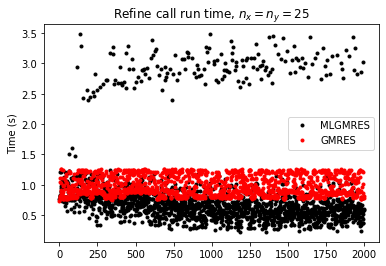

In [10]:
pp.plot(run_timeP2_ML_list,'.k',label='MLGMRES')
pp.plot(GmresRunTimeOriginal2,'.r',label='GMRES')
pp.title('Refine call run time, $n_x=n_y=25$')
pp.ylabel('Time (s)')
pp.legend(loc='best')
pp.savefig('EntireTime1.png')

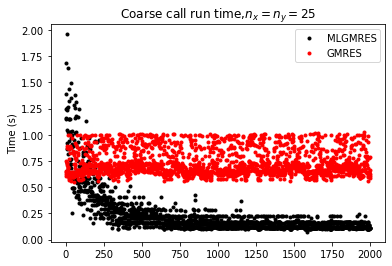

In [11]:
pp.plot(run_timeP1_ML_list,'.k',label='MLGMRES')
pp.plot(GmresRunTimeOriginal,'.r',label='GMRES')
pp.title('Coarse call run time,$n_x=n_y=25$')
pp.ylabel('Time (s)')
pp.legend(loc='best')
pp.savefig('EntireTime2.png')

/home/kl748/Research/NERSC/GMRES-Learning/src_dir/util.py:68: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(a[-Window-1:-1])/Window


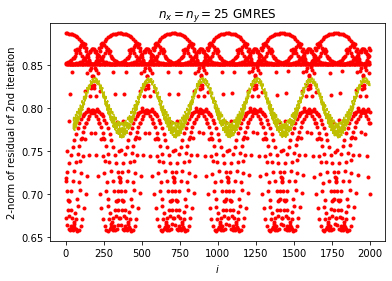

In [12]:
AVG=np.zeros((n_steps,1))
Err_Array=np.asarray(NonML_Err_List)
count=np.arange(0,n_steps)

for j in range(0,n_steps):
    AVG[j]=moving_average(np.asarray(Err_Array[:j]),j)

    
    
pp.plot(count,np.asarray(NonML_Err_List),'.r',count[50:-1],AVG[50:-1],'--y')
pp.xlabel('$i$')
pp.ylabel('2-norm of residual of 2nd iteration')
pp.title('$n_x=n_y=25$ GMRES')
pp.savefig('GMRES.png')

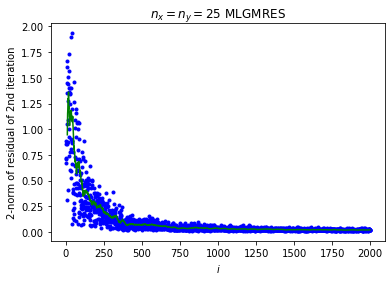

In [13]:
Err_Array_ML=np.asarray(Err_list)
AVGML=np.zeros((n_steps,1))

for j in range(0,n_steps):
    AVGML[j]=moving_average(np.asarray(Err_Array_ML[:j]),j)

pp.plot(count,np.asarray(Err_Array_ML),'.b',count[10:-1],AVGML[10:-1],'g')
pp.xlabel('$i$')
pp.ylabel('2-norm of residual of 2nd iteration')
pp.title('$n_x=n_y=25$ MLGMRES')
pp.savefig('MLGMRES.png')

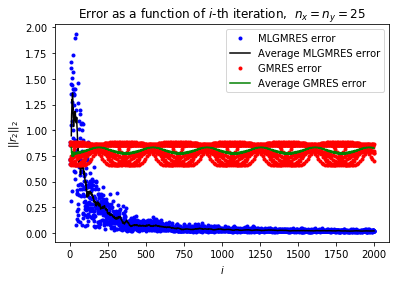

In [14]:
pp.plot(count,Err_Array_ML,'.b',label='MLGMRES error')
pp.plot(count[10:-1],AVGML[10:-1],'k',label='Average MLGMRES error')
pp.plot(count,Err_Array,'.r',label='GMRES error')
pp.plot(count[10:-1],AVG[10:-1],'g',label='Average GMRES error')

pp.xlabel('$i$')
pp.ylabel('$||r_2||_2$')
pp.title('Error as a function of $i$-th iteration,  $n_x=n_y=25$ ')
pp.legend(loc='best')
pp.savefig('Compare.png')

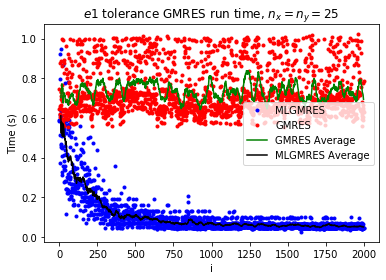

In [15]:
GmresRunTimeOriginal_AVG=np.zeros((n_steps,1))
ML_GMRES_Time_AVG=np.zeros((n_steps,1))


for j in range(0,n_steps):
    GmresRunTimeOriginal_AVG[j]=moving_average(np.asarray(GmresRunTimeOriginal[:j]),j)

for j in range(0,n_steps):
    ML_GMRES_Time_AVG[j]=moving_average(np.asarray(ML_GMRES_Time_list[:j]),j)
    
    
pp.plot(ML_GMRES_Time_list,'.b',label='MLGMRES')
pp.plot(GmresRunTimeOriginal,'.r', label='GMRES')
pp.plot(count[10:-1],GmresRunTimeOriginal_AVG[10:-1],'g', label='GMRES Average')
pp.plot(count[10:-1],ML_GMRES_Time_AVG[10:-1],'k', label='MLGMRES Average')

pp.ylabel('Time (s)')
pp.xlabel('i')
pp.title('$e1$ tolerance GMRES run time, $n_x=n_y=25$')
pp.legend(loc='best')
pp.savefig('Runtime.png')

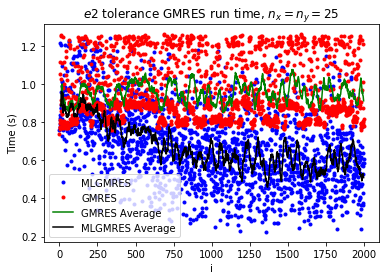

In [16]:
GmresRunTimeOriginal2_AVG=np.zeros((n_steps,1))
ML_GMRES_Time2_AVG=np.zeros((n_steps,1))
count=np.arange(0,n_steps)


for j in range(0,n_steps):
    GmresRunTimeOriginal2_AVG[j]=moving_average(np.asarray(GmresRunTimeOriginal2[:j]),j)

for j in range(0,n_steps):
    ML_GMRES_Time2_AVG[j]=moving_average(np.asarray(ML_GMRES_Time_list2[:j]),j)
    
    
pp.plot(ML_GMRES_Time_list2,'.b',label='MLGMRES')
pp.plot(GmresRunTimeOriginal2,'.r', label='GMRES')
pp.plot(count[10:-1],GmresRunTimeOriginal2_AVG[10:-1],'g', label='GMRES Average')
pp.plot(count[10:-1],ML_GMRES_Time2_AVG[10:-1],'k', label='MLGMRES Average')

pp.ylabel('Time (s)')
pp.xlabel('i')
pp.title('$e2$ tolerance GMRES run time, $n_x=n_y=25$')
pp.legend(loc='best')
pp.savefig('Runtime2.png')

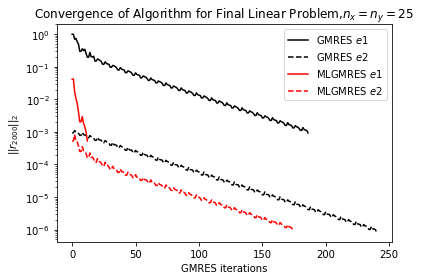

In [17]:
ML_Err=resid(A, Out, b/b_norm)
ML_Err2=resid(A, Out2, b/b_norm)



NonML_Err=resid(A, NonML_Out1, b/b_norm)
NonML_Err2=resid(A, NonML_Out2, b/b_norm)

pp.semilogy(NonML_Err,'k',label='GMRES $e1$')
pp.semilogy(NonML_Err2,'--k',label='GMRES $e2$')
pp.semilogy(ML_Err,'r',label='MLGMRES $e1$')
pp.semilogy(ML_Err2,'--r',label='MLGMRES $e2$')
pp.legend(loc='best')
pp.xlabel('GMRES iterations')
pp.ylabel('$||r_{2000}||_2$')
pp.title('Convergence of Algorithm for Final Linear Problem,$n_x=n_y=25$')
pp.savefig('Error.png')